## Project Title: Understanding graduation rates to student success and professional development

### Team Number: 11
### Team Members: 
- Pranava Kadiyala (pskadiya@andrew.cmu.edu)
- Matthew Wu (mrw2@andrew.cmu.edu)
- Hiba Hassan (hibah@andrew.cmu.edu)

### Target Variable: X3CLGANDWORK (X3 Status for attending college and working)
- 1: Both Postsecondary classes and working/apprenticing 
- 2: Postsecondary classes only                              
- 3: Working/apprenticing only                               
- 4: Neither taking classes nor working/apprenticing        
- 5: Undecided or not known              
- -8: Unit non-response                

### Question: How does education level influence Post Secondary Education and Employment Outcomes?
- The main idea is to identify factors that may be related to whether or not an individual pursues postsecondary education, opts for work opportunities or neither of the two
- The analysis is conducted by applying the classification technique in machine learning to breakdown segments of features that maybe influencing this outcome 

In [26]:
#Importing relevant libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn import metrics
from sklearn.metrics import r2_score 
import time
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils import resample

from imblearn.over_sampling import SMOTE, RandomOverSampler

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import GridSearchCV
from yellowbrick.model_selection import ValidationCurve

%matplotlib inline

---
## Outline

- Data Processing
- Feature Engineering and Feature Selection
- Model Tuning, Validation and Selection
- Feature Importance 
- Visualizations and Answering the Question

---
## 1) Data Setup and Data Cleaning

### Data Summary

In [27]:
seed=4

In [28]:
#Importing the relevant csv data file
df = pd.read_csv("data/hsls_17_students_clean.csv")
df.head()

,STU_ID,X2UNIV1,X2UNIV2A,X2UNIV2B,X3UNIV1,X4UNIV1,W1STUDENT,W2STUDENT,W3STUDENT,W4STUDENT,...,S2MUSIC,S2ART,S2DRAMA,S2SPORTS,S2CLUB,S2ACADEMIC,S3HSCRED,S3FOCUS,S3CLGFT,S3WORKFT
0,10001,11,1,1,1111,11111,375.667105,365.607062,392.215779,466.860846,...,0,1,0,1,1,0,1,1,1,-6
1,10002,11,1,1,1111,11111,189.309446,196.338045,236.571468,254.811585,...,1,0,0,0,0,0,1,1,1,2
2,10003,11,1,1,1111,11111,143.591863,137.678887,148.736833,156.626153,...,0,0,0,1,0,0,1,1,1,2
3,10005,11,1,1,1111,11111,145.019401,134.566242,152.708389,148.440875,...,1,1,0,0,0,0,1,-8,3,-8
4,10006,11,1,1,1111,11110,56.347833,56.495653,64.969992,0.000000,...,1,0,0,1,1,0,1,1,1,-6


In [29]:
#Initial data structure
df.shape

(17762, 214)

In [30]:
pd.options.display.max_rows = 1000
df.isnull().sum()

STU_ID              0
X2UNIV1             0
X2UNIV2A            0
X2UNIV2B            0
X3UNIV1             0
X4UNIV1             0
W1STUDENT           0
W2STUDENT           0
W3STUDENT           0
W4STUDENT           0
X1SEX               0
X1RACE              0
X1STDOB             0
X1TXMTSCOR          0
X1HHNUMBER          0
X1SES_U             0
X1MTHID             0
X1SCIID             0
X1SCHOOLBEL         0
X1SCHOOLENG         0
X1STU30OCC_STEM1    0
X1STUEDEXPCT        0
X1PAREDEXPCT        0
X1TESTSTAT          0
X1SQSTAT            0
X1CONTROL           0
X1LOCALE            0
X1REGION            0
X2ENROLSTAT         0
X2EVERDROP          0
X2DROPSTAT          0
X2NUMHS             0
X2TXMTSCOR          0
X2HHNUMBER          0
X2SES_U             0
X2BEHAVEIN          0
X2PROBLEM           0
X2MTHID             0
X2SCIID             0
X2STU30OCC_STEM1    0
X2STUEDEXPCT        0
X2PAREDEXPCT        0
X2TESTSTAT          0
X2SQSTAT            0
X2CONTROL           0
X2LOCALE  

In [31]:
df['X3CLGANDWORK'].value_counts()

-8    5934
 1    5348
 2    4065
 3    1821
 4     594
Name: X3CLGANDWORK, dtype: int64

### Dealing with Variables for Analysis

###### For analysing X3CLGANDWORK we drop variables from later rounds as we are trying to deduce how current/past factors influence post graduation and employment

In [32]:
# Removing X4 X5 Vars
x4x5 = []
for c in df.columns:
    if c[:2] == 'X4' or c[:2] == 'X5' or c[:2] == 'W4':
        x4x5.append(c)
df = df.drop(x4x5, axis=1)

In [33]:
columns = df.columns.tolist()

In [34]:
#Generating the list of tracking variables so that they are not included in the feature list used for modelling.
track_type = ['STU_ID', 'X2UNIV1', 'X2UNIV2A', 'X2UNIV2B', 'X3UNIV1', 'W1STUDENT', 'W2STUDENT', 'W3STUDENT',
              'X1TESTSTAT', 'X1SQSTAT', 'X2TESTSTAT', 'X2SQSTAT', 'X3SQSTAT']

In [35]:
#columns without tracking variables
col_no_track = list(set(columns) - set(track_type))

In [36]:
#Generating the list categorical variables in the new data frame

cat_type = ['X1SEX', 'X1RACE', 'X1STU30OCC_STEM1', 'X2STU30OCC_STEM1', 'X1CONTROL', 'X2CONTROL', 'X3CONTROL', 
            'X1LOCALE', 'X2LOCALE', 'X3LOCALE', 'X1REGION', 'X2REGION', 'X3REGION', 'X2ENROLSTAT',  'X2DROPSTAT', 'X2EVERDROP', 
            'X3DROPOUTTIME', 'X3DROPSTAT', 'X3EVERDROP', 'X3PROGLEVEL', 'X3CLGANDWORK', 'X3EVERGED', 'X3HSCOMPSTAT', 'X4HSCOMPSTAT',
           'X3ELLSTATUS','X4HSCOMPSTAT','X4EVRTRANSHS_R','X4EVRAPPCLG','X4PS1SELECT','X4REFDEGTYPE','X4PSENRSTLV',
            'X4RFDGCOMP','X4INCOMECAT','X4HSCLGCRED','X4REFSECTOR',
            'X4PS1DEGTYPE1','X4PSLFSTFB16','X4OCCFB2','X5LASTENR16','X5STEMCRED','X5PS1SEC',
            'X4EVERGED','X4EVR2YPUB','X4REFLEVEL','X4FB16ENRSTAT','X4RFDGMJSTEM','X4OCCFBSTEM1',
            'X5CTECRED','X4GEDPASSED','X4ATNDCLG16FB','X4PS1SECTOR','X4REFSELECT','X4ATPRLVLA','X4RFDGMJ123',
            'X4OCC30RELATE','X5PS1SLC','X4SQSTAT','X4EVERDROP','X4PS1LEVEL','X4ATNDCLG16FB','X4PS1LEVEL','X4REFDEGTYPE','X4PSENRSTLV','X4RFDGCOMP','X4INCOMECAT',
            'X4PS1SELECT','X4PS1DEGTYPE1','X4PSLFSTFB16','X4OCCFB2','X5LASTENR16','X5STEMCRED','X4EVERDROP','X4EVRAPPCLG','X4REFSECTOR',
            'X4FB16ENRSTAT','X4OCCFBSTEM1','X5CTECRED','X4EVRTRANSHS_R','X4REFLEVEL','X4ATPRLVLA','X4OCC30RELATE',
            'X5PS1SLC','X4HSCLGCRED','X4EVR2YPUB','X4PS1SECTOR','X4REFSELECT','X5PS1SEC','X5PFYSEC','X4ATNDCLG16FB',
            'X4PS1LEVEL','X4REFDEGTYPE','X4PSENRSTLV','X4RFDGCOMP','X4GEDPASSED','X4PS1SELECT','X4PS1DEGTYPE1','X4OCCFB2','X5STEMCRED','X4REFSECTOR',
            'X4OCCFBSTEM1','X5CTECRED','X4REFLEVEL','X4ATPRLVLA','X4OCC30RELATE','X4PS1SECTOR','X4REFSELECT',
            'X5LASTENR16','X5STEMCRED','X5CTECRED','X5PS1SLC','X5PS1SEC', 'X5SRRESP', 'X5PFYSLC', 'X5PFYDEGREE', 'X5PFYDEGREE', 'S1FAVSUBJ', 'S2GRD1112',
           'S2PASSGRADE', 'S2EDUEXP', 'S2CLG2013', 'S2FOCUS2013', 'S2CLGFT2013', 'S2AFFOCCTRN', 'S2AFF2YPUB', 'S2AFF4YIN', 'S2AFF4YOUT', 'S2AFF4YPRV', 'S2AFF4YSEL',
           'S2NEVERCLG', 'S2CANTAFFORD', 'S2MUSIC', 'S2ART', 'S2DRAMA', 'S2SPORTS', 'S2CLUB', 'S2ACADEMIC', 'S3HSCRED', 'S3FOCUS', 'S3CLGFT', 'S3WORKFT', 
            'S2SUREDIPL', 'S2INSCHSUSP', 'S1S8', 'S1HRWORK', 'S1WEBINFO', 'S1SUREHSGRAD', 'S1SCHWASTE', 'X1HHNUMBER',
           'X2HHNUMBER', 'X1PAREDEXPCT', 'X2PAREDEXPCT', 'X2STUEDEXPCT', 'X1STUEDEXPCT', 'S1M8', 'S1SAFE', 'S2SATNUM',
           'S1HRACTIVITY', 'S2ARRESTED', 'S1GOODGRADES', 'S1M8GRADE', 'S1S8GRADE', 'X2NUMHS', 'S2SCHWASTE']


cat_type_x4x5 = []
for c in cat_type:
    if c[:2] == 'X4' or c[:2] == 'X5' or c[:2] == 'S4' or c[:2] == 'S5':
        cat_type_x4x5.append(c)
cat_type_x1x2x3 = list(set(cat_type)-set(cat_type_x4x5))

#For the classification task, I am also interested in  how the panel 1 and panel 2 impact the classification, 
#generating alist of X3 categorical variables that I will not include in the model
cat_type_x3 = []
for c in cat_type:
    if c[:2] == 'X3' or c[:2] == 'S3':
        cat_type_x3.append(c)
cat_type_x1x2 = list(set(cat_type_x1x2x3)-set(cat_type_x3))



In [37]:
#Generating the list of numerical variables in the new data frame
num_type_x1x2x3 = list(set(col_no_track)-set(cat_type_x1x2x3))

#Creating a numerical list of X1 and X2 variables that dont consist of X3                           
num_type_x3 = []
for c in num_type_x1x2x3:
    if c[:2] == 'X3' or c[:2] == 'S3':
        num_type_x3.append(c)

num_type_x1x2 = list(set(num_type_x1x2x3)-set(num_type_x3))

In [38]:
features = pd.concat([df[cat_type_x1x2], df[num_type_x1x2]], axis=1)

###### We use panel 1 and panel 2 data variables that were collected in 2009 and 2012, respectively

In [39]:
#making the categorical adtype category
features[cat_type_x1x2] = features[cat_type_x1x2].astype('category')
features[cat_type_x1x2].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17762 entries, 0 to 17761
Data columns (total 57 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   S2CLGFT2013       17762 non-null  category
 1   S1M8GRADE         17762 non-null  category
 2   S2ART             17762 non-null  category
 3   X2HHNUMBER        17762 non-null  category
 4   X1RACE            17762 non-null  category
 5   S2MUSIC           17762 non-null  category
 6   S2NEVERCLG        17762 non-null  category
 7   S1SUREHSGRAD      17762 non-null  category
 8   X2STUEDEXPCT      17762 non-null  category
 9   S1M8              17762 non-null  category
 10  S1S8GRADE         17762 non-null  category
 11  S1GOODGRADES      17762 non-null  category
 12  S2FOCUS2013       17762 non-null  category
 13  S2ACADEMIC        17762 non-null  category
 14  S1WEBINFO         17762 non-null  category
 15  S1S8              17762 non-null  category
 16  S2CLG2013         1776

In [40]:
#We generate age variables from X1STDOB
features['X1AGE'] = 2009 - features['X1STDOB'].astype(str).str[:4].astype('int64')

#dropping X1STDOB
features = features.drop(columns='X1STDOB')

num_type_x1x2x3 = list(set(num_type_x1x2x3)-set(['X1STDOB']))
num_type_x1x2 = list(set(num_type_x1x2)-set(['X1STDOB']))

##### Exploratory Data Visualization
- The following general visualization is done to understand the general data structure for each of the variables and see if there are perhaps inbalances/outliers

/var/folders/hl/7rbfybxj1ks3wksbymkm9dr40000gn/T/ipykernel_18505/1215325875.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(column)


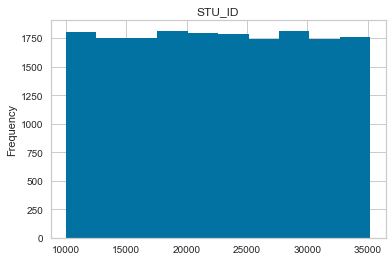

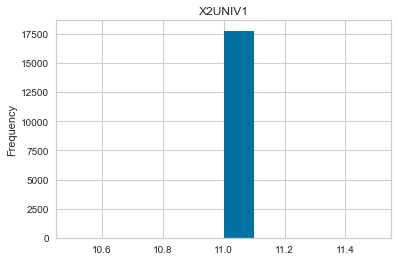

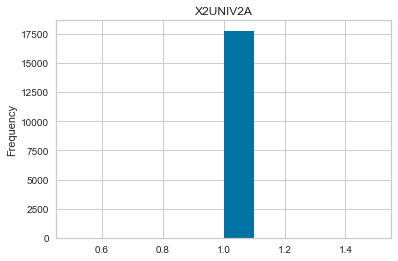

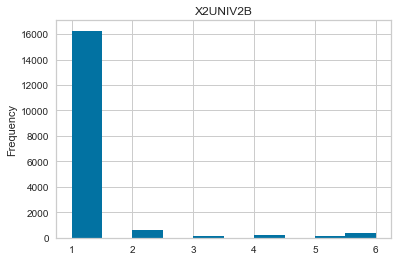

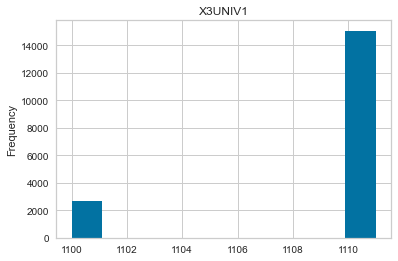

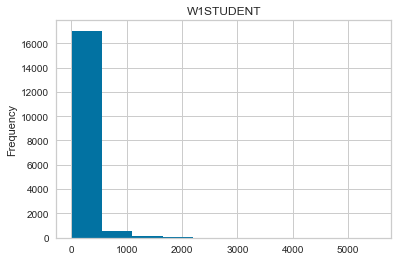

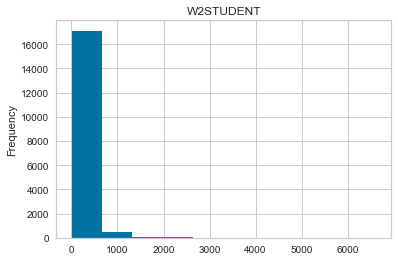

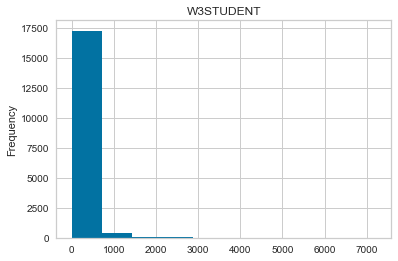

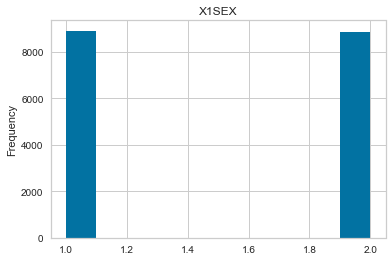

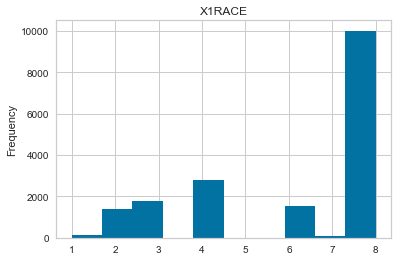

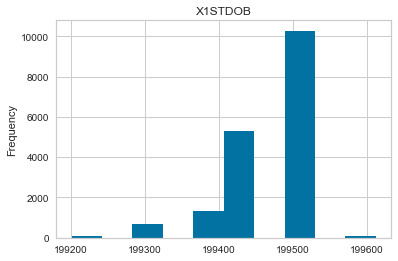

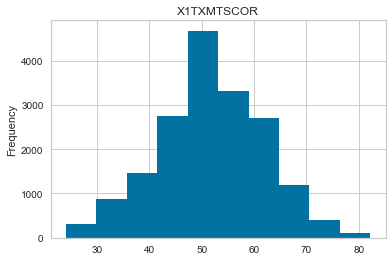

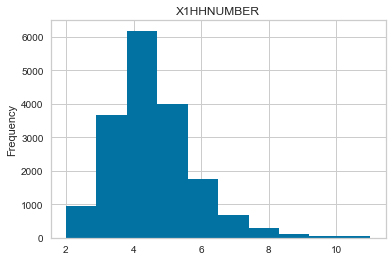

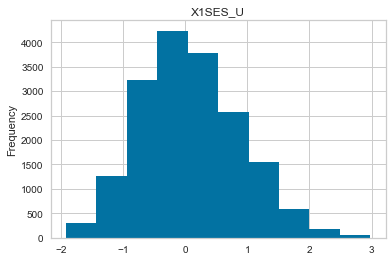

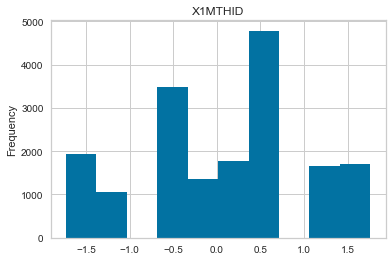

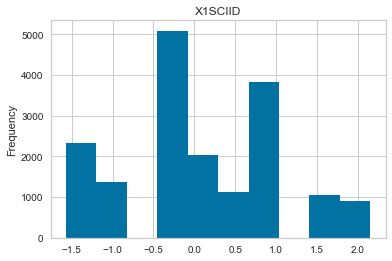

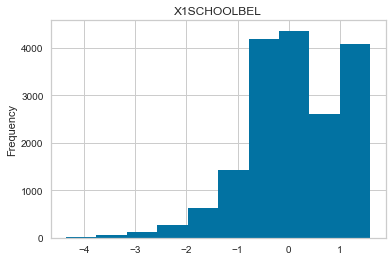

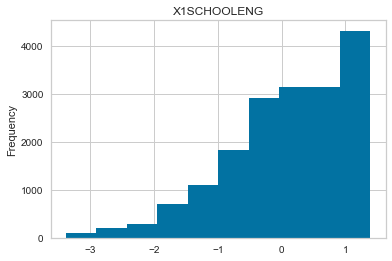

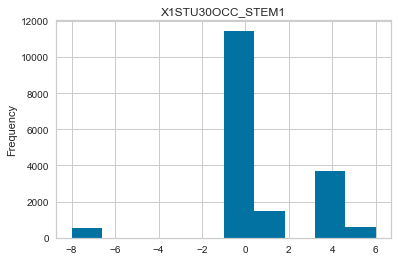

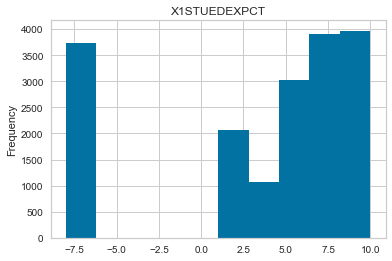

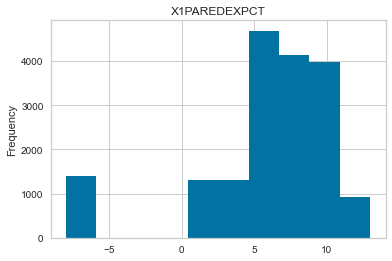

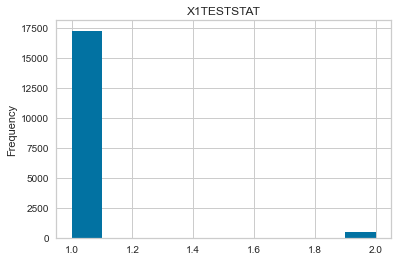

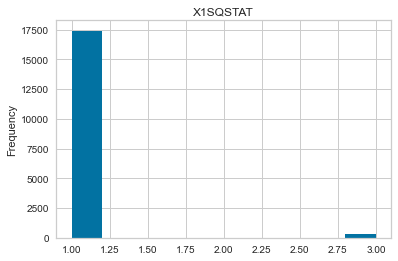

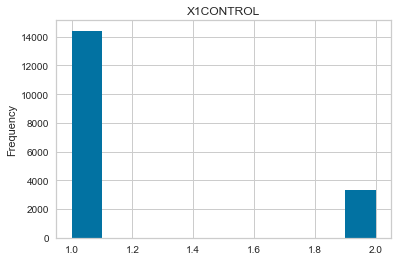

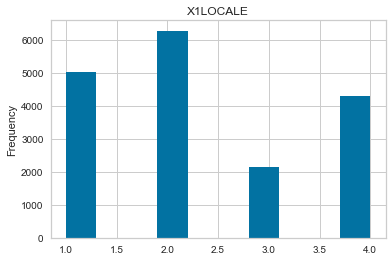

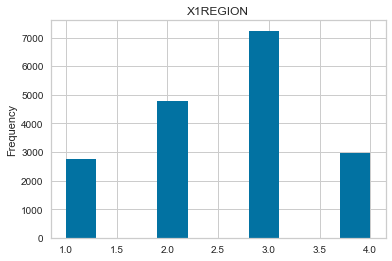

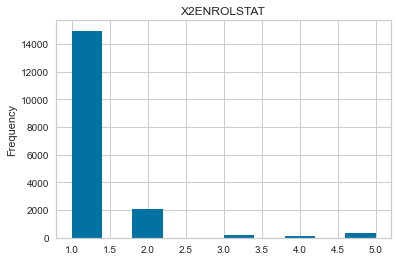

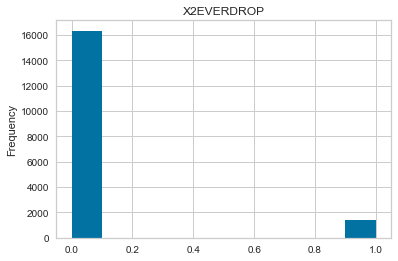

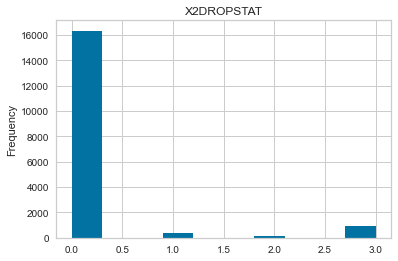

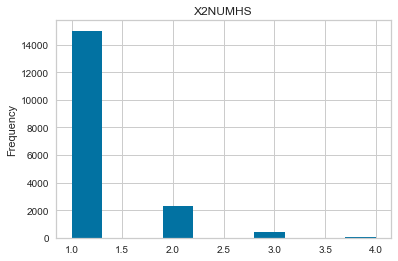

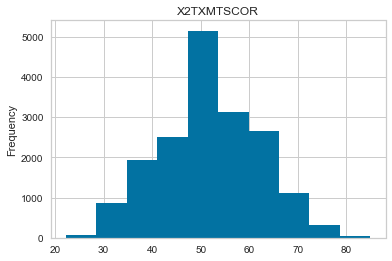

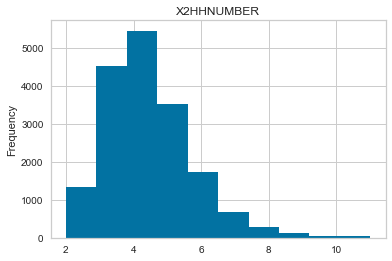

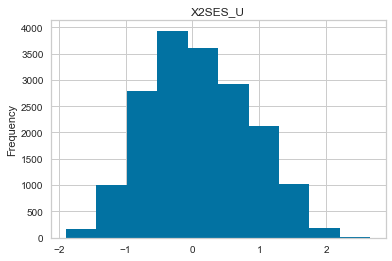

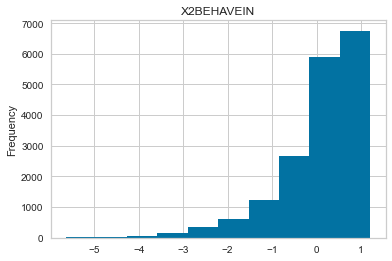

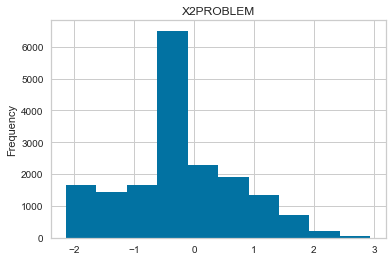

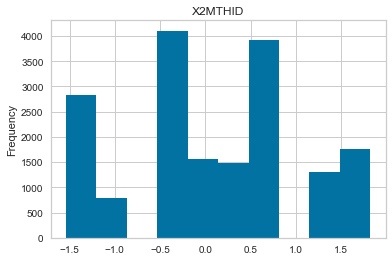

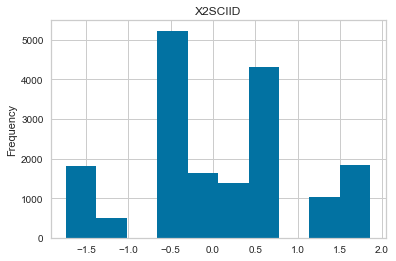

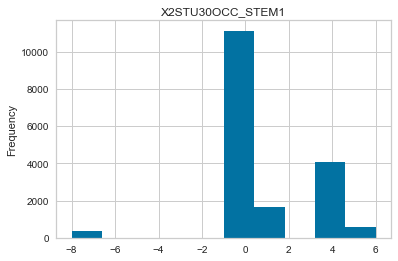

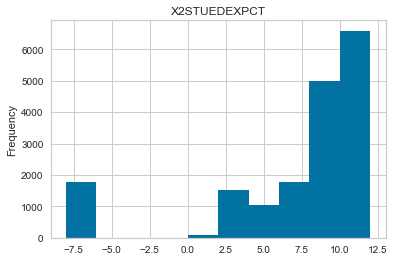

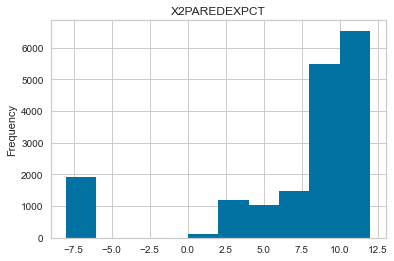

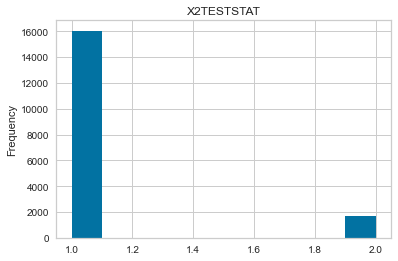

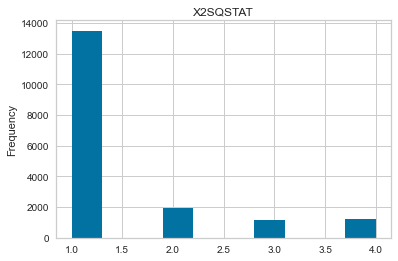

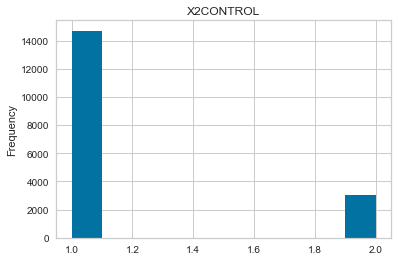

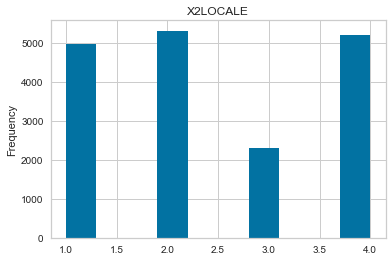

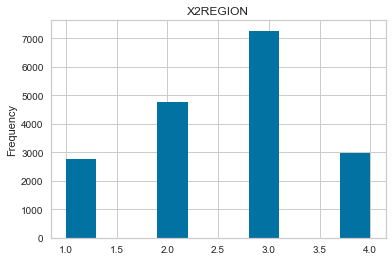

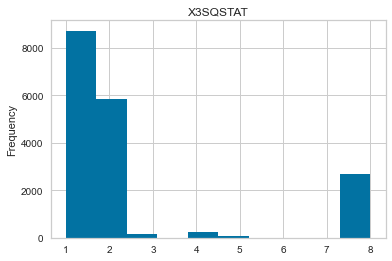

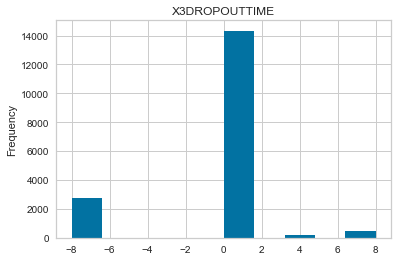

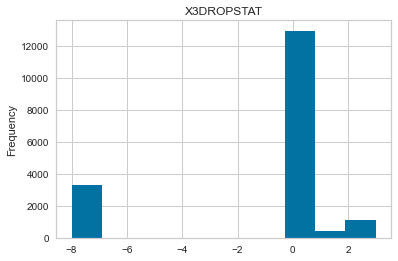

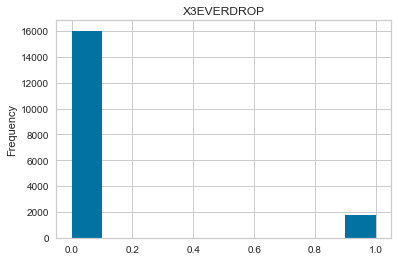

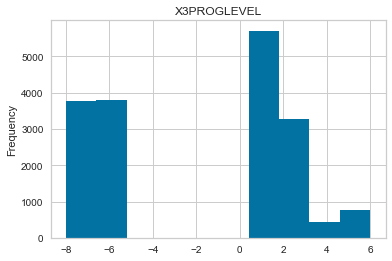

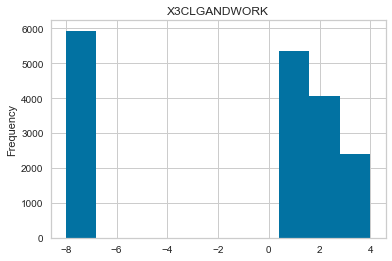

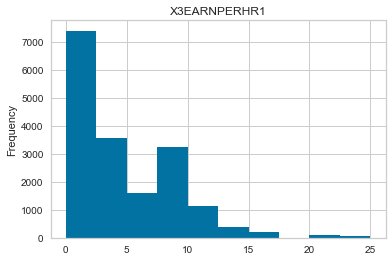

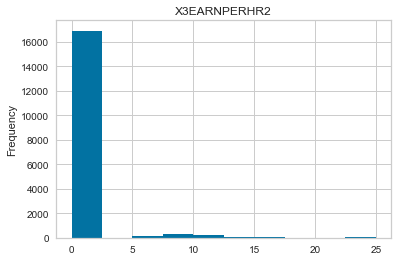

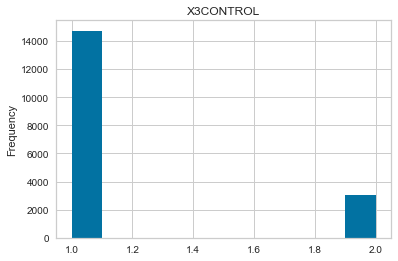

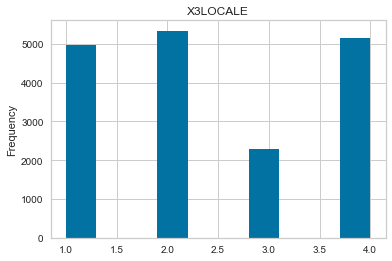

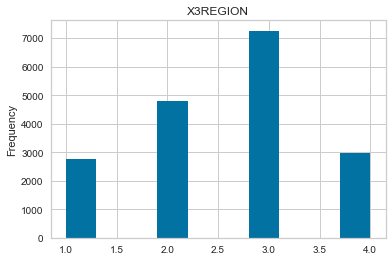

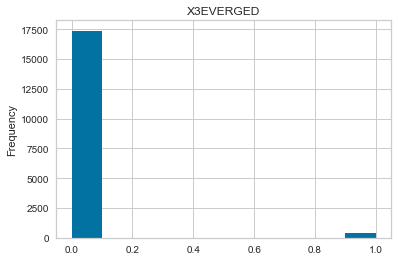

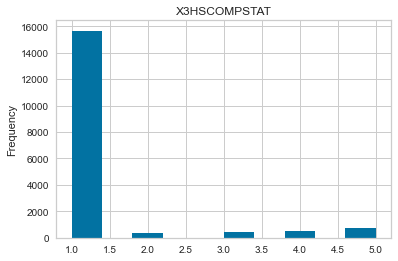

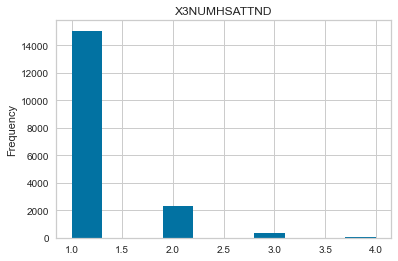

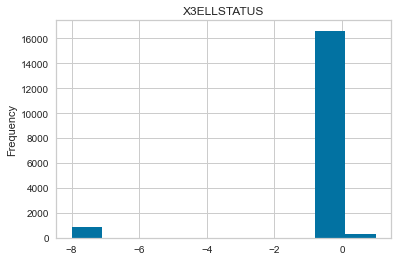

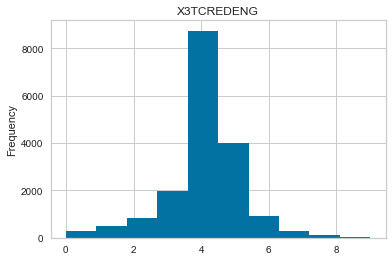

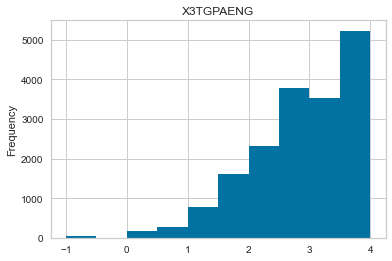

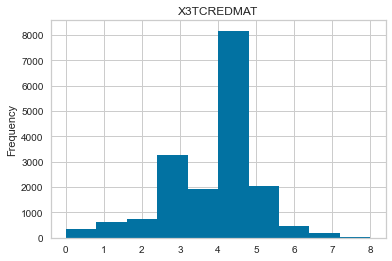

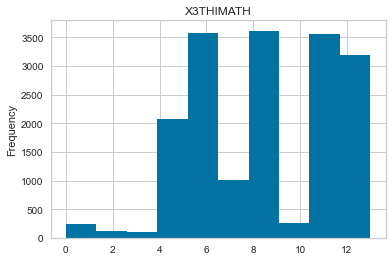

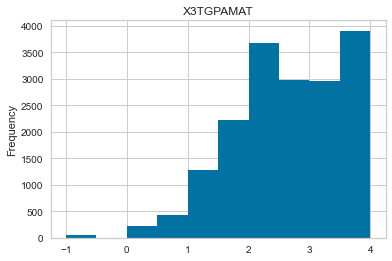

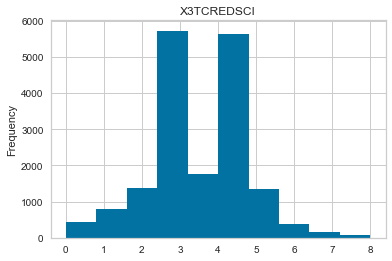

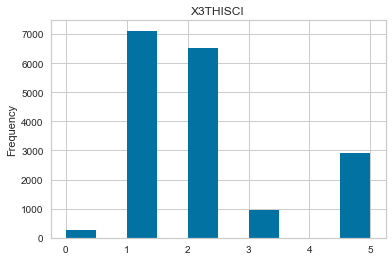

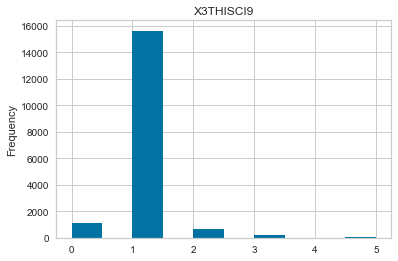

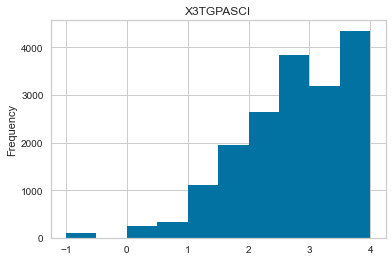

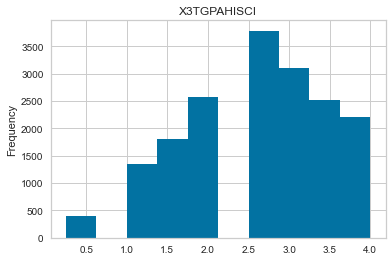

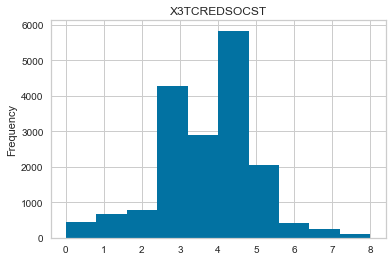

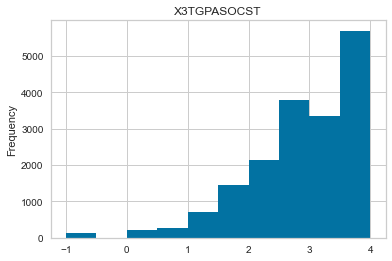

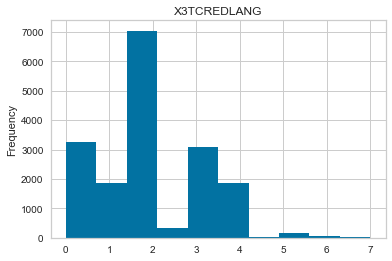

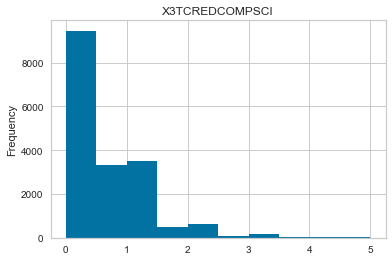

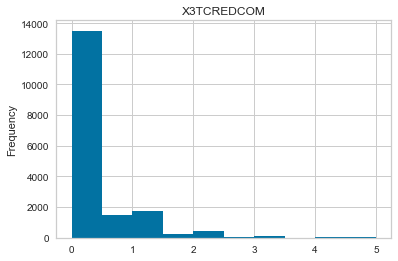

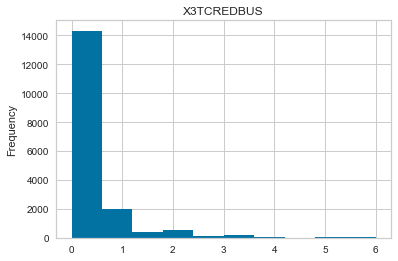

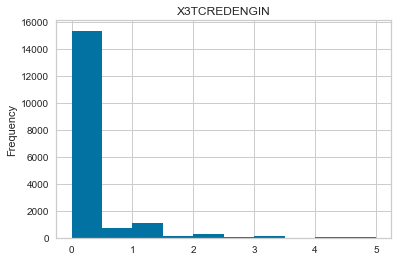

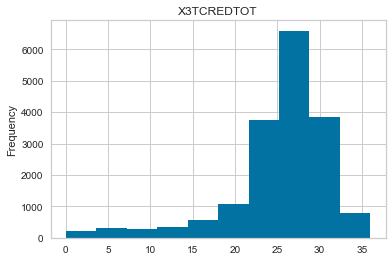

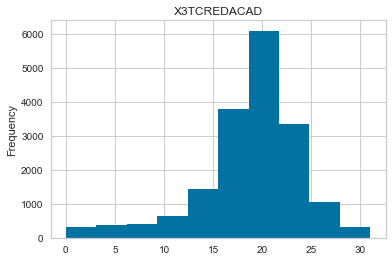

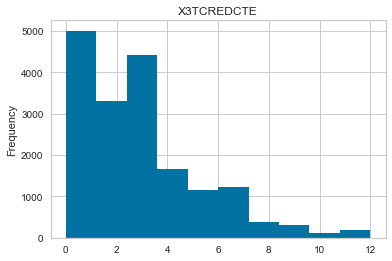

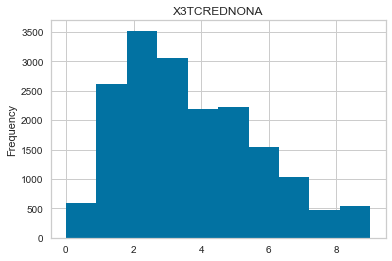

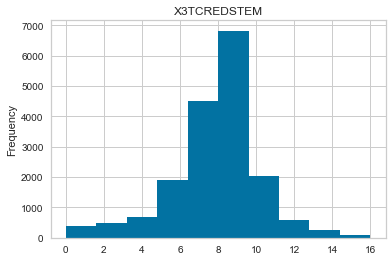

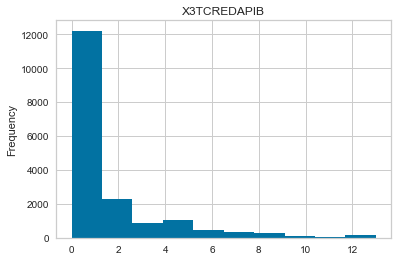

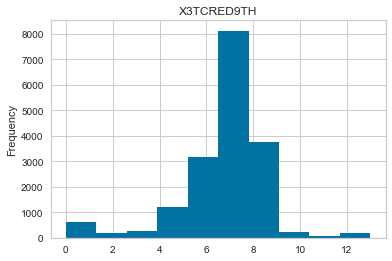

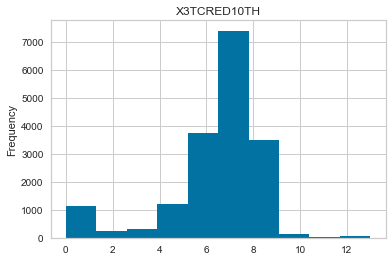

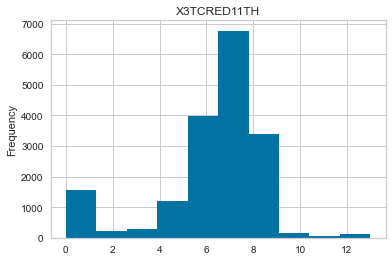

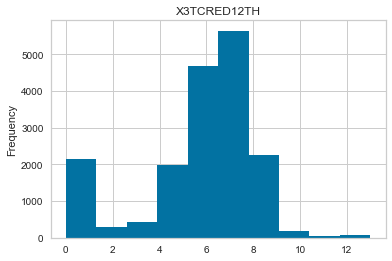

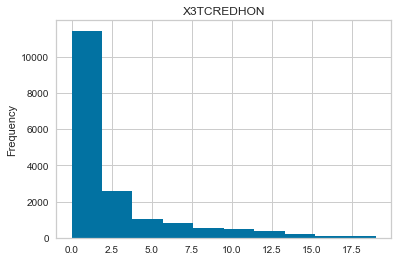

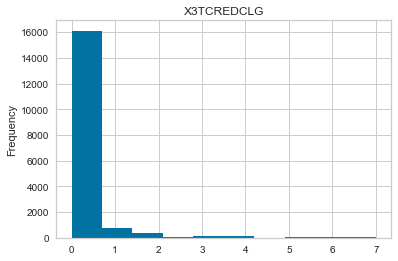

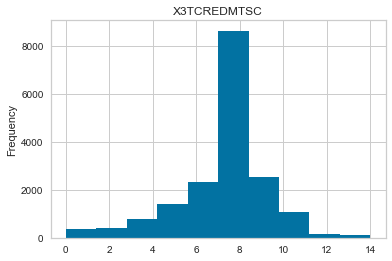

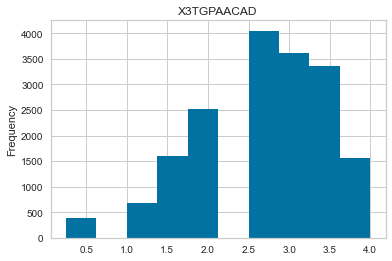

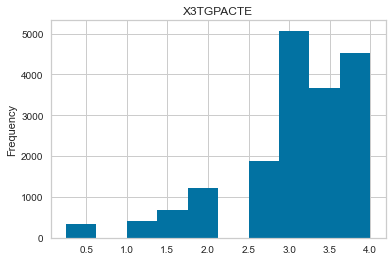

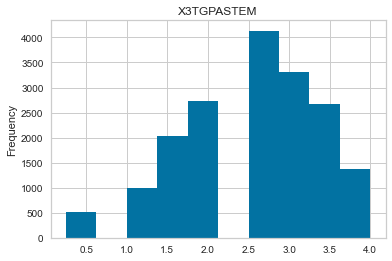

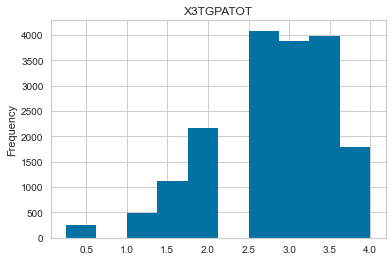

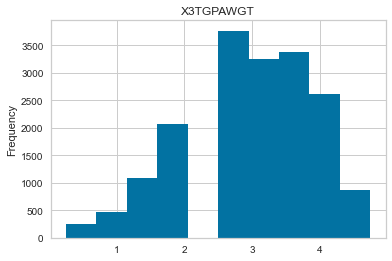

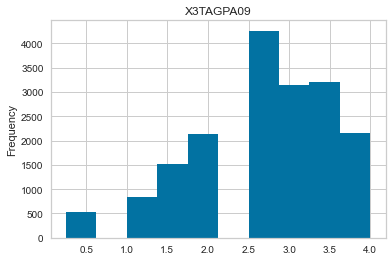

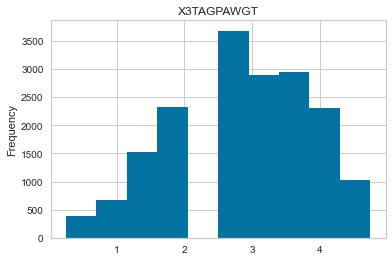

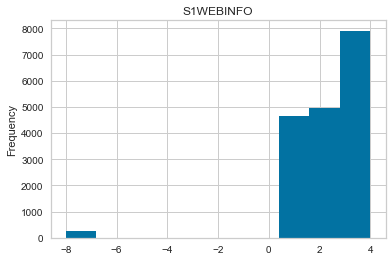

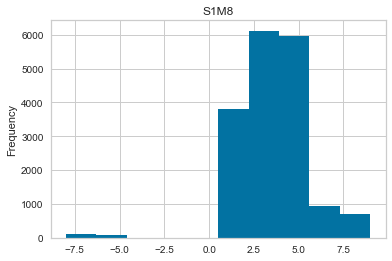

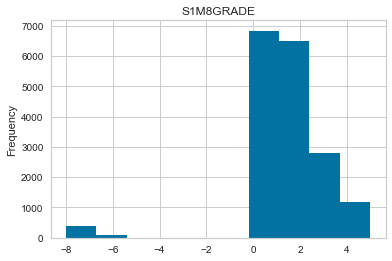

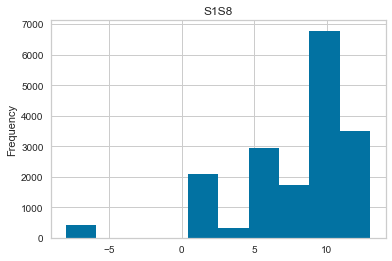

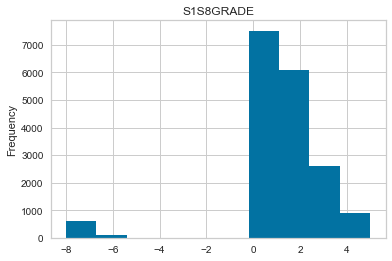

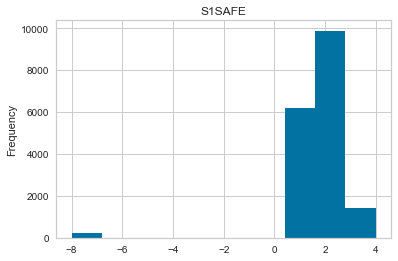

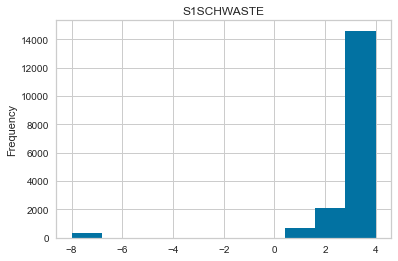

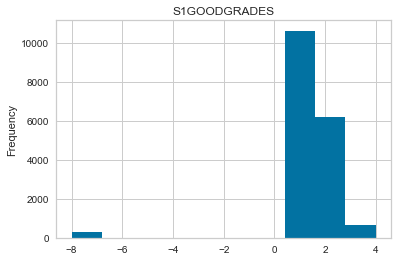

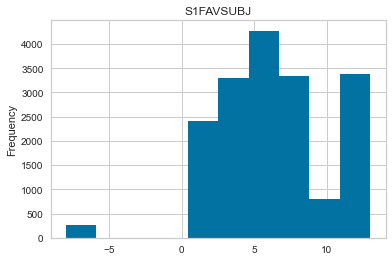

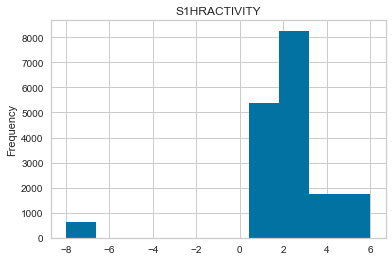

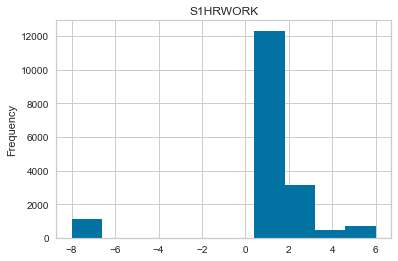

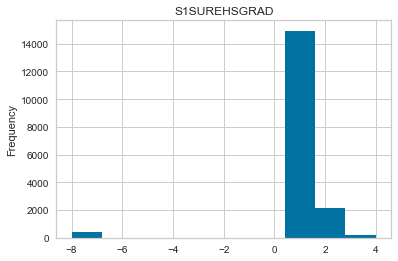

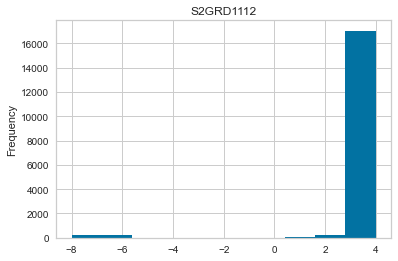

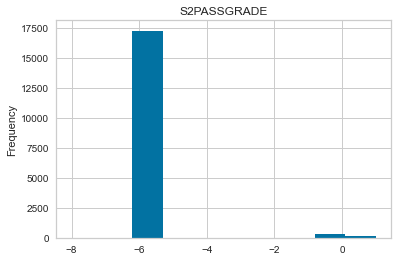

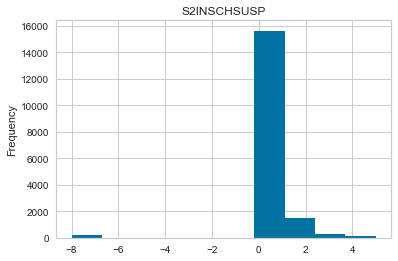

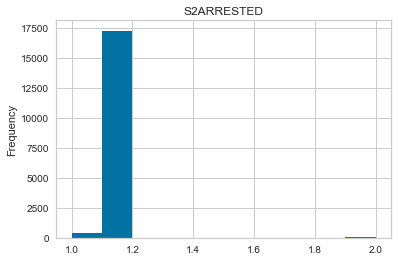

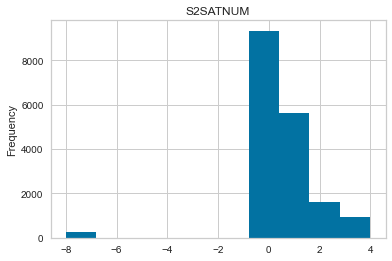

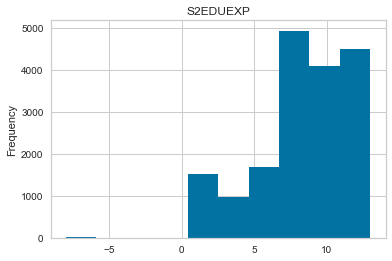

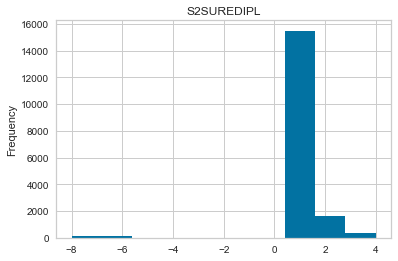

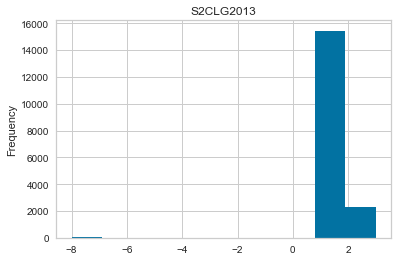

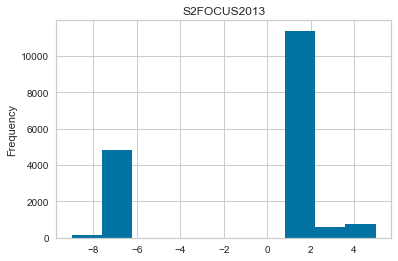

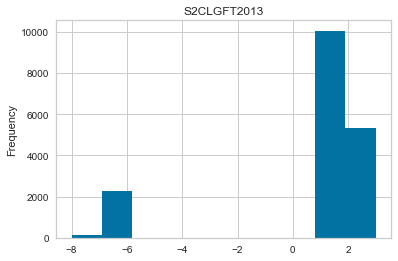

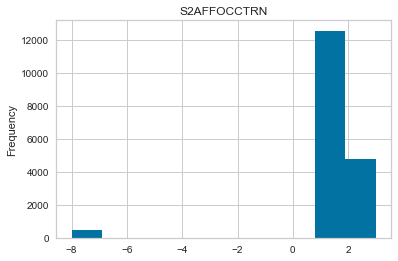

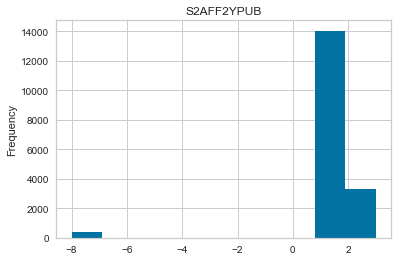

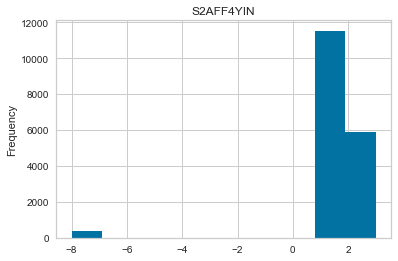

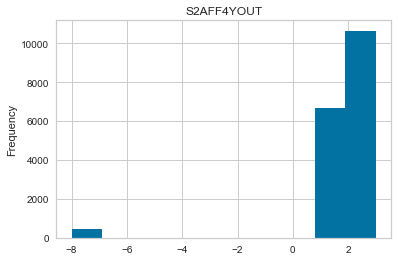

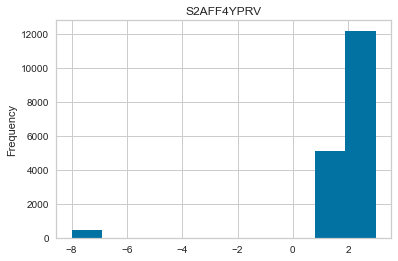

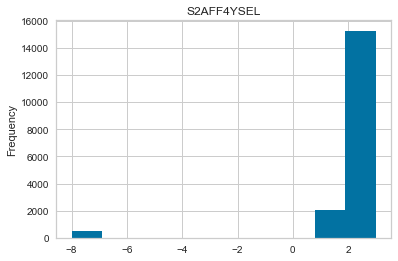

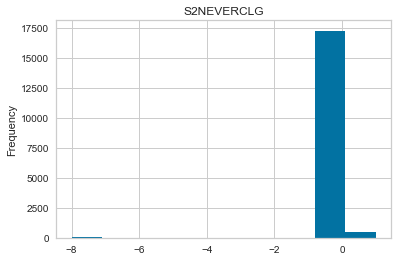

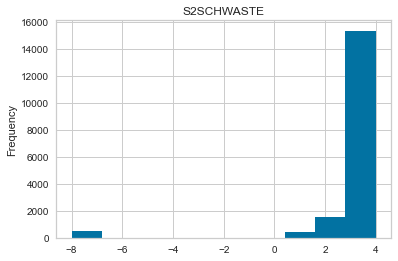

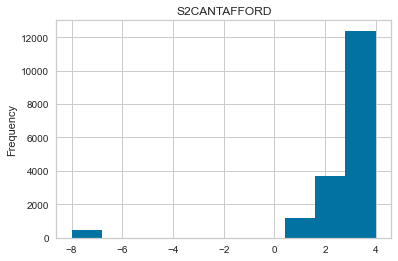

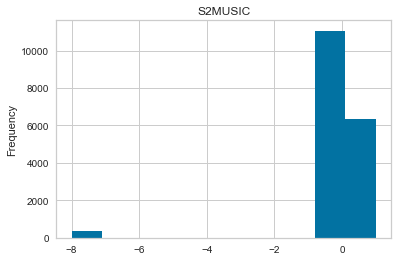

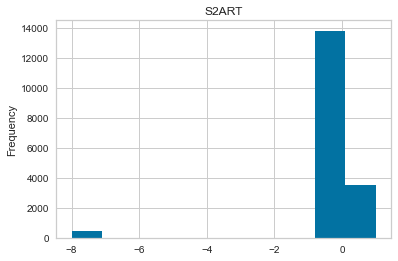

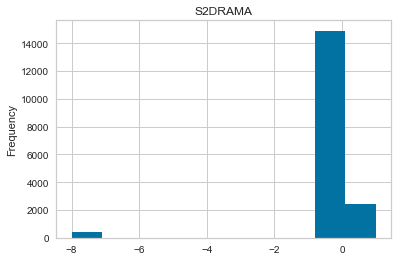

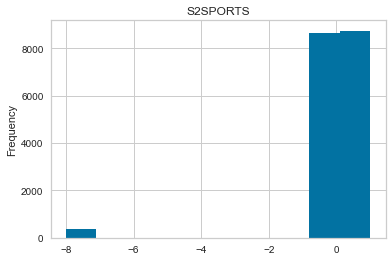

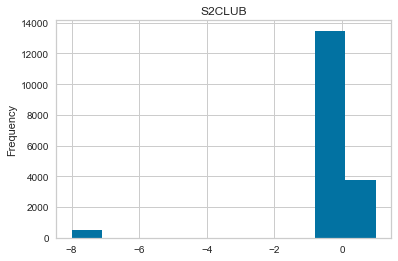

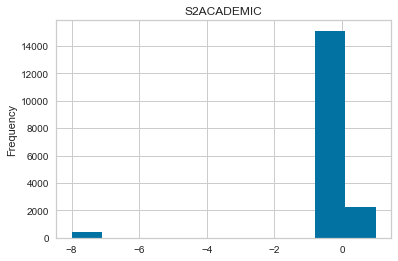

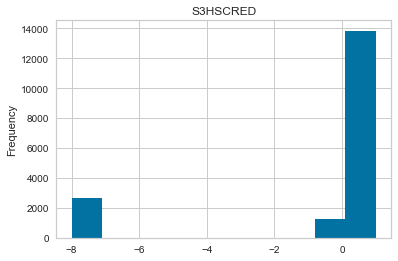

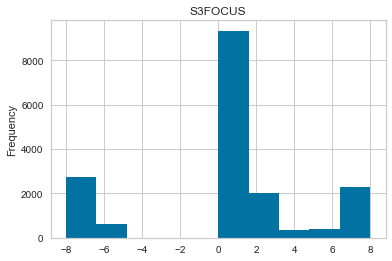

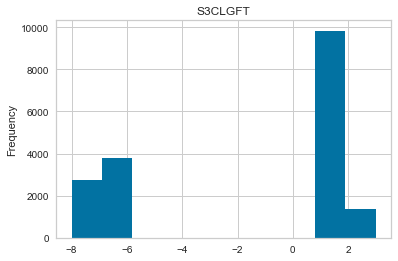

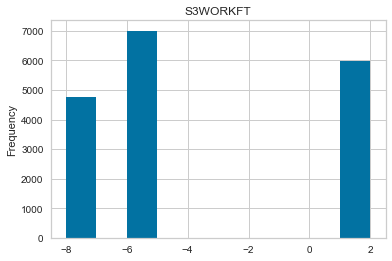

In [41]:
##EDA For Variables
from pandas.api.types import is_numeric_dtype, is_string_dtype

#A for loop is used to iterate through all columns in the dataframe and create:
## - histogram for categorical 
## - bar plot for numerical

for column in df:
    plt.figure(column)
    plt.title(column)
    if is_numeric_dtype(df[column]):
        df[column].plot(kind='hist')
    elif is_string_dtype(df[column]):
        #show only the top 20  value count in each categorical data
        df[column].value_counts()[:20].plot(kind='bar')

---
## 2) Feature Engineering and Feature Selection

In [42]:
#some of these categorical variables regquire ordinal encoding rather than using them as dummies for each group
cat_ord_type_x1x2 = ['S2INSCHSUSP', 'S1HRWORK', 'S1WEBINFO', 'S1SCHWASTE', 'X2HHNUMBER', 'X2PAREDEXPCT', 'X1PAREDEXPCT',
                    'X2STUEDEXPCT', 'X1STUEDEXPCT', 'X1HHNUMBER', 'S1SAFE', 'S2SATNUM', 'S1HRACTIVITY', 'S1GOODGRADES',
                    'S1M8GRADE', 'S1S8GRADE', 'X2NUMHS', 'S2SCHWASTE']

cat_type_x1x2 = list(set(cat_type_x1x2) - set(cat_ord_type_x1x2))

In [43]:
#Generating dummies for all categorical variables
pd_dummy = pd.get_dummies(data=features[cat_type_x1x2])
features_new = pd.concat([features,pd_dummy],axis=1).drop(columns=cat_type_x1x2)

y = df['X3CLGANDWORK']
X = features_new.copy()

In [44]:
#Train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
y_test

14053    3
6004    -8
8964    -8
17400    1
6328     1
        ..
9065     1
1431    -8
11801   -8
12537    1
12258    1
Name: X3CLGANDWORK, Length: 4441, dtype: int64

### Classification Models Selection
The classification models chosen for variable/question analysis are as follows:
1. Logistic Regression (LR)
- We use logistic regression as we care about interpretability in terms of how our selected set of variables influence postsecondary education and employment outcomes. While LR is not the best model in terms of accuracy, given that our target variable is categorical, it is a good starting point to deduce what features may have some level of influence on it.

2. Random Forest (RF)
- We use Random Forest as it is one of the strongest classification models that would enable us to accurately identify the strongest features for our analysis, is highly accurate in classification tasks and would be able to easily handle our vastly spread panel data. 

3. Gradient Boosting (GB)
- We use Gradient Boosting as it is particularly useful in accurately predicting trends and analysis based on the panel data we have. Secondly, GB helps us identify the most important features that help us streamline our analysis.

Overall, alternative models KNN, Naive Bayes etc are not essentially as useful or strong in terms of dealing with complex, panel data. Naive Bayes classififcation models are also not appropriate because they make independence assumptions for the features of our model - given that this is a panel data set - this assumption is not valid.

In [45]:
#standardising numerical variables in X_train 
scaler = RobustScaler()
X_train[num_type_x1x2] = scaler.fit_transform(X_train[num_type_x1x2])

Using Robust Scaler because standard scaler assumes normally distributed features which is not the case with the numerical data in our sample. 

In [46]:
#dealing with ordinal categorical variables
encoder = OrdinalEncoder()
X_train[cat_ord_type_x1x2] = encoder.fit_transform(X_train[cat_ord_type_x1x2])

In [47]:
#upscaling
sm = SMOTE(random_state=seed)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

### Feature selection

In [48]:
#feature selection
X_train.columns.tolist()

['S1M8GRADE',
 'X2HHNUMBER',
 'X2STUEDEXPCT',
 'S1S8GRADE',
 'S1GOODGRADES',
 'S1WEBINFO',
 'X2NUMHS',
 'S1SCHWASTE',
 'X2PAREDEXPCT',
 'X1STUEDEXPCT',
 'S2INSCHSUSP',
 'X1PAREDEXPCT',
 'S1HRWORK',
 'S2SATNUM',
 'X1HHNUMBER',
 'S1SAFE',
 'S2SCHWASTE',
 'S1HRACTIVITY',
 'X2BEHAVEIN',
 'X1SCHOOLBEL',
 'X1SCHOOLENG',
 'X1MTHID',
 'X1SES_U',
 'X2MTHID',
 'X2TXMTSCOR',
 'X1SCIID',
 'X1TXMTSCOR',
 'X2PROBLEM',
 'X2SCIID',
 'X2SES_U',
 'X1AGE',
 'S2AFFOCCTRN_-8',
 'S2AFFOCCTRN_1',
 'S2AFFOCCTRN_2',
 'S2AFFOCCTRN_3',
 'S2EDUEXP_-8',
 'S2EDUEXP_1',
 'S2EDUEXP_2',
 'S2EDUEXP_3',
 'S2EDUEXP_4',
 'S2EDUEXP_5',
 'S2EDUEXP_6',
 'S2EDUEXP_7',
 'S2EDUEXP_8',
 'S2EDUEXP_9',
 'S2EDUEXP_10',
 'S2EDUEXP_11',
 'S2EDUEXP_12',
 'S2EDUEXP_13',
 'S2CLGFT2013_-8',
 'S2CLGFT2013_-6',
 'S2CLGFT2013_1',
 'S2CLGFT2013_2',
 'S2CLGFT2013_3',
 'S2SPORTS_-8',
 'S2SPORTS_0',
 'S2SPORTS_1',
 'S2ART_-8',
 'S2ART_0',
 'S2ART_1',
 'S2SUREDIPL_-8',
 'S2SUREDIPL_-6',
 'S2SUREDIPL_1',
 'S2SUREDIPL_2',
 'S2SUREDIPL_3',
 'S2SURE

In [49]:
X_train_smote.shape

(22405, 225)

### SelectFromModel
- To ensure comparability acorss all models we use a feature selection method that is supported by all models so that we can find the same set of best features for all models for accurate comparability.

- We choose SelectFromModel feature selector for this purpose - given our focus on inference and feature importance and also computational efficiency, SelectFromModel suits these objectives the best

#### Logistic Regression and SelectFromModel

In [50]:
start = time.time()

#for logistic regression
lr_selector = SelectFromModel(LogisticRegression(max_iter=10000, random_state=seed))
lr_selector.fit(X_train_smote, y_train_smote)
lr_selected = lr_selector.get_support()
print(X_train_smote.columns[lr_selected])
lr_sel = X_train_smote.columns[lr_selected].tolist()

computation_time = (time.time()-start)
print("Computation time (seconds): %5.3f"%computation_time)

Index(['S2AFFOCCTRN_-8', 'S2EDUEXP_-8', 'S2EDUEXP_1', 'S2EDUEXP_3',
       'S2EDUEXP_5', 'S2EDUEXP_6', 'S2EDUEXP_7', 'S2EDUEXP_8', 'S2EDUEXP_9',
       'S2EDUEXP_10',
       ...
       'S2ARRESTED_1.0', 'S2ARRESTED_1.1179883945841391', 'X2DROPSTAT_3',
       'S2AFF4YIN_-8', 'S2AFF4YIN_1', 'X1SEX_1', 'X1SEX_2', 'S2PASSGRADE_-8',
       'S2PASSGRADE_-6', 'S2PASSGRADE_0'],
      dtype='object', length=109)
Computation time (seconds): 46.618


#### Random Forest and SelectFromModel

In [51]:
pipe = Pipeline([
    ('feature_selection', SelectFromModel(RandomForestClassifier())),
    ('classification', RandomForestClassifier(random_state=seed))
])

start = time.time()

parameters = {'feature_selection__threshold': [0, '0.25*mean', '0.5*mean', 'mean', '1.25*mean'] }

grid = GridSearchCV(pipe, parameters, cv=5).fit(X_train_smote, y_train_smote)

best_threshold = grid.best_estimator_.named_steps['feature_selection'].threshold
rf_sel = X_train_smote.columns[grid.best_estimator_.named_steps['feature_selection'].get_support()].tolist()
print("Best threshold for Random Forest:", best_threshold)
print('\n')
print("Selected features from Random Forest:", rf_sel)

computation_time = (time.time()-start)
print('\n')
print('\n')
print("Computation time (seconds): %5.3f"%computation_time)

Best threshold for Random Forest: 1.25*mean


Selected features from Random Forest: ['S1M8GRADE', 'X2HHNUMBER', 'X2STUEDEXPCT', 'S1S8GRADE', 'S1GOODGRADES', 'S1WEBINFO', 'X2NUMHS', 'S1SCHWASTE', 'X2PAREDEXPCT', 'X1STUEDEXPCT', 'S2INSCHSUSP', 'X1PAREDEXPCT', 'S1HRWORK', 'S2SATNUM', 'X1HHNUMBER', 'S1SAFE', 'S2SCHWASTE', 'S1HRACTIVITY', 'X2BEHAVEIN', 'X1SCHOOLBEL', 'X1SCHOOLENG', 'X1MTHID', 'X1SES_U', 'X2MTHID', 'X2TXMTSCOR', 'X1SCIID', 'X1TXMTSCOR', 'X2PROBLEM', 'X2SCIID', 'X2SES_U', 'X1AGE', 'S2CLGFT2013_1', 'S2SPORTS_0', 'S2SPORTS_1', 'X1RACE_8', 'S2FOCUS2013_-7', 'S2FOCUS2013_1', 'S2CLG2013_1', 'S2AFF4YPRV_1', 'S2AFF4YOUT_1', 'S2AFF4YIN_1', 'X1SEX_1', 'X1SEX_2']




Computation time (seconds): 192.270


#### Gradient Boosting and SelectFromModel

In [52]:
start = time.time()

gb_selector = SelectFromModel(GradientBoostingClassifier(random_state=seed))
gb_selector.fit(X_train_smote, y_train_smote)
gb_selected = gb_selector.get_support()
print(X_train_smote.columns[gb_selected])
gb_sel = X_train_smote.columns[gb_selected].tolist()

computation_time = (time.time()-start)
print("Computation time (seconds): %5.3f"%computation_time)

Index(['S1M8GRADE', 'X2HHNUMBER', 'X2STUEDEXPCT', 'S1S8GRADE', 'S1GOODGRADES',
       'S1WEBINFO', 'X2NUMHS', 'S1SCHWASTE', 'X2PAREDEXPCT', 'X1STUEDEXPCT',
       'S2INSCHSUSP', 'X1PAREDEXPCT', 'S1HRWORK', 'S2SATNUM', 'S1SAFE',
       'S2SCHWASTE', 'S1HRACTIVITY', 'X2BEHAVEIN', 'X1SCHOOLENG', 'X1SES_U',
       'X2TXMTSCOR', 'X1SCIID', 'X1TXMTSCOR', 'X2PROBLEM', 'X2SCIID',
       'X2SES_U', 'S2AFFOCCTRN_1', 'S2AFFOCCTRN_2', 'S2AFFOCCTRN_3',
       'S2CLGFT2013_1', 'S2CLGFT2013_2', 'S2CLGFT2013_3', 'S2SPORTS_0',
       'S2SPORTS_1', 'X1RACE_4', 'X1RACE_8', 'S2MUSIC_1', 'S1SUREHSGRAD_2',
       'S2AFF2YPUB_1', 'S1M8_3', 'S1M8_4', 'S2FOCUS2013_-7', 'S2FOCUS2013_1',
       'S2CLG2013_1', 'S2AFF4YPRV_1', 'S2AFF4YSEL_2', 'X2LOCALE_1',
       'X2LOCALE_2', 'S2AFF4YOUT_1', 'X1LOCALE_1', 'X1LOCALE_2', 'X1LOCALE_4',
       'X2ENROLSTAT_1', 'X1REGION_3', 'X1CONTROL_2', 'S2CANTAFFORD_2',
       'S2AFF4YIN_1', 'S2AFF4YIN_2', 'S2AFF4YIN_3', 'X1SEX_1', 'X1SEX_2'],
      dtype='object')
Computation tim

##### Intersection and Final Features

In [53]:
#intersection of features from all these selector supports
rf_lr_selected = set(rf_sel).intersection(set(lr_sel))
selected = list(rf_lr_selected.intersection(set(gb_sel)))
print(selected)

#Finalizing XTrain and XTest
X_train_smote_final = X_train_smote[selected]
X_test_final = X_test[selected]

['S2FOCUS2013_-7', 'X1SEX_1', 'S2CLG2013_1', 'S2FOCUS2013_1', 'S2AFF4YIN_1', 'X1RACE_8', 'S2CLGFT2013_1', 'S2AFF4YPRV_1', 'X1SEX_2']


In [54]:
X_train_smote_final

,S2FOCUS2013_-7,X1SEX_1,S2CLG2013_1,S2FOCUS2013_1,S2AFF4YIN_1,X1RACE_8,S2CLGFT2013_1,S2AFF4YPRV_1,X1SEX_2
0,0,0,1,1,1,1,0,0,1
1,0,1,1,1,1,1,0,1,0
2,0,1,1,0,0,0,1,0,0
3,0,1,1,1,1,0,1,1,0
4,1,1,1,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...
22400,0,0,1,0,1,1,0,0,0
22401,0,0,1,0,0,0,0,0,0
22402,0,1,0,0,1,0,0,0,0
22403,0,0,0,0,0,0,0,0,0


---
## 3) Model Training, Tuning, Validation
- Logistic Regression
- Random Forest
- Gradient Boosting

#### Logistic Regression

In [55]:
#hyperparameter tuning logistic regression
start = time.time()
lr = LogisticRegression(max_iter=10000, random_state=seed)
parameters = {'solver'  : ['lbfgs', 'liblinear','newton-cg','sag','saga']}
tuning_lr = GridSearchCV(lr,                     # model
                      param_grid = parameters,   # hyperparameters
                      scoring='accuracy',        # metric for scoring
                      cv=10)
tuning_lr.fit(X_train_smote_final,y_train_smote)
print("The tuned parameters are:", tuning_lr.best_params_)

computation_time = (time.time()-start)
print("Computation time (seconds): %5.3f"%computation_time)

The tuned parameters are: {'solver': 'liblinear'}
Computation time (seconds): 10.938


                              precision    recall  f1-score   support

Postsecondary classes & Work      0.404     0.275     0.327      1453
  Postsecondary classes only      0.406     0.450     0.427      1352
                Working Only      0.390     0.543     0.454      1025
                     Neither      0.266     0.174     0.210       465
                 No-Response      0.096     0.144     0.115       146

                    accuracy                          0.375      4441
                   macro avg      0.312     0.317     0.307      4441
                weighted avg      0.377     0.375     0.368      4441



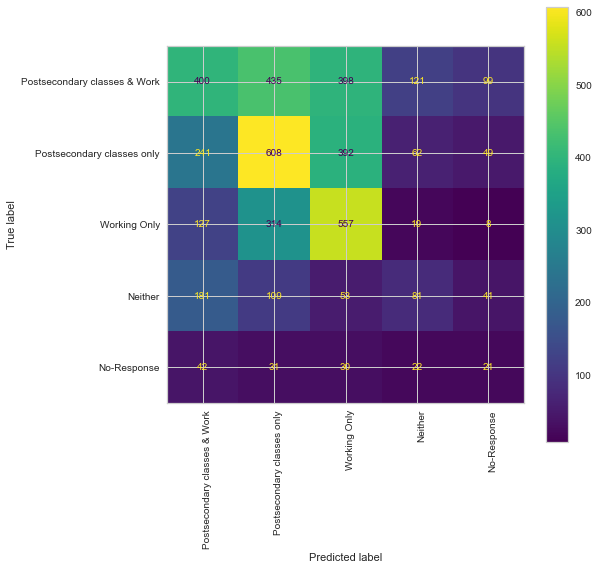

In [56]:
#Running logistic regression with the best performing parameters
lr = LogisticRegression(max_iter=10000, solver='liblinear', random_state=seed)
lr.fit(X_train_smote_final, y_train_smote)

lr_pred = lr.predict(X_test_final)

#Plotting the confusion Matrix
cm_lr = confusion_matrix(y_test, lr_pred)

fig, ax = plt.subplots(figsize=(8, 8))
display_cm_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr,
                                       display_labels=['Postsecondary classes & Work',
                                                       'Postsecondary classes only',
                                                       'Working Only', 'Neither',
                                                       'No-Response'])
display_cm_lr.plot(ax=ax)

# Rotate the tick labels
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

# The classification report
print(classification_report(y_test, lr_pred, digits=3,
                            target_names=['Postsecondary classes & Work',
                                          'Postsecondary classes only',
                                          'Working Only', 'Neither',
                                          'No-Response']))

#### Random Classifier

In [57]:
#hyperparameter tuning Random Classifier
start = time.time()
rf = RandomForestClassifier(random_state=seed)
parameters = {'n_estimators'  : [50, 100, 150, 200],
              'max_depth': [5, 10, 20, 30, None],
             'min_samples_split': [2, 5, 7, 10]}
tuning_rf = GridSearchCV(rf,                     # model
                      param_grid = parameters,   # hyperparameters
                      scoring='accuracy',        # metric for scoring
                      cv=10)
tuning_rf.fit(X_train_smote_final,y_train_smote)
print(tuning_rf.best_params_)

computation_time = (time.time()-start)
print("Computation time (seconds): %5.3f"%computation_time)

{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Computation time (seconds): 459.259


                              precision    recall  f1-score   support

Postsecondary classes & Work      0.389     0.189     0.255      1453
  Postsecondary classes only      0.386     0.530     0.446      1352
                Working Only      0.402     0.481     0.438      1025
                     Neither      0.280     0.247     0.263       465
                 No-Response      0.104     0.171     0.129       146

                    accuracy                          0.366      4441
                   macro avg      0.312     0.324     0.306      4441
                weighted avg      0.370     0.366     0.352      4441



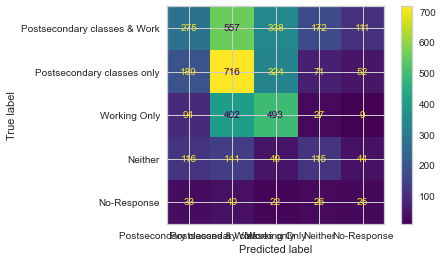

In [58]:
#running random forest with the best performing parameters
rf = RandomForestClassifier(max_depth= 20, min_samples_split = 2, n_estimators = 250, random_state=seed)
rf.fit(X_train_smote_final,y_train_smote)

rf_pred = rf.predict(X_test_final)

#Plotting confusion matrix
cm_rf = confusion_matrix(y_test, rf_pred)
display_cm_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf,display_labels=['Postsecondary classes & Work','Postsecondary classes only','Working Only', 'Neither', 'No-Response'])
display_cm_rf.plot()

#The Classification Report
print(classification_report(y_test, rf_pred, digits=3, target_names=['Postsecondary classes & Work','Postsecondary classes only','Working Only', 'Neither', 'No-Response']))

#### Gradient Boosting

In [59]:
#hyperparameter tuning Gradient Boosting
start = time.time()
gb = GradientBoostingClassifier(random_state=seed)
parameters = {'n_estimators'  : [50, 100, 150],
              'max_depth': [10, 20, 30],
             'learning_rate': [0.001, 0.01, 0.1]}
tuning_gb = GridSearchCV(gb,                     # model
                      param_grid = parameters,   # hyperparameters
                      scoring='accuracy',        # metric for scoring
                      cv=10)
tuning_gb.fit(X_train_smote_final,y_train_smote)
print(tuning_gb.best_params_)

computation_time = (time.time()-start)
print("Computation time (seconds): %5.3f"%computation_time)

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 150}
Computation time (seconds): 2153.578


                              precision    recall  f1-score   support

Postsecondary classes & Work      0.388     0.188     0.253      1453
  Postsecondary classes only      0.397     0.501     0.443      1352
                Working Only      0.399     0.538     0.458      1025
                     Neither      0.280     0.247     0.263       465
                 No-Response      0.104     0.171     0.129       146

                    accuracy                          0.370      4441
                   macro avg      0.314     0.329     0.309      4441
                weighted avg      0.373     0.370     0.355      4441



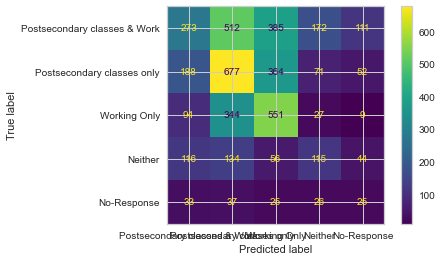

In [60]:
#running Gradient Boosting with the best performing parameters
gb = GradientBoostingClassifier(max_depth= 10, learning_rate = 0.1, n_estimators = 150, random_state=seed)
gb.fit(X_train_smote_final,y_train_smote)

gb_pred = gb.predict(X_test_final)

#Plotting the confusion matrix
cm_gb = confusion_matrix(y_test, gb_pred)
display_cm_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb, display_labels=['Postsecondary classes & Work','Postsecondary classes only','Working Only', 'Neither', 'No-Response'])
display_cm_gb.plot()

#Classification report
print(classification_report(y_test, gb_pred, digits=3, target_names=['Postsecondary classes & Work','Postsecondary classes only','Working Only', 'Neither', 'No-Response']))

### Model Selection
##### Accuracy, Precision, Recall and f1-score
- Accuracy: comparing the accuracy of the three models, we observe a similar average level across all three with 
    - Logistic Regression: 37.5%
    - Random Classifier: 36.5%
    - Gradient Boosting: 37% 
- Precision: comparing the precision for the three models, we observe that the 'Postsecondary classes & Work' is best classified by the Logistic Regression model at a 40% level. Other classes are also comparatively, more correctly classified by Logistic Regression as compared to other models
- Recall: comparing the recall for the three models, we see a varied analysis however, in specific for the 'Postsecondary classes & Work' the lowest recall is that of Gradient Booster. 

##### Selected Model: Logistic Regression
Taking these three and other values into account, we can say that the Logistic Model has overall performed better and will be our selected model for analysis

##### AUC-ROC Curve
- We initially had planned on integrating an AUC-ROC curve to refine our analysis for final model selection however, given that the target variable is a multi-class categorical variable, the AUC-ROC model is not able to support it.

- We check to see if the high accuracy is a result of very high correlation between the features and the target variable
- Essentially, we want to avoid a situation where one of the features' relationship with the target is one-on-one such that using the feature is as good as using the target variable.

In [70]:
#seeing correlation of the features finally selected with the target variable
corr_df = pd.concat([X_train_smote_final, y_train], axis=1)
corr_matrix = corr_df.corr()
print(corr_matrix.iloc[-1, :-1].sort_values())

S2CLGFT2013_1    -0.014826
X1SEX_2          -0.011732
S2CLG2013_1      -0.006913
S2AFF4YPRV_1     -0.006747
S2FOCUS2013_-7   -0.003333
X1RACE_8         -0.003088
S2FOCUS2013_1    -0.000871
S2AFF4YIN_1       0.000525
X1SEX_1           0.011407
Name: X3CLGANDWORK, dtype: float64


____
## 4) Feature Importance 

##### Logistic Regression 

In [65]:
#Logistic Rergession
fimp_lr = pd.DataFrame({'Features':X_train_smote_final.columns, 'Importance': np.array(lr.coef_[0])})

Text(0, 0.5, 'Feature Names')

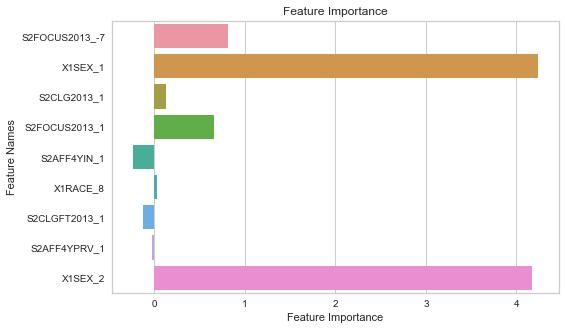

In [66]:
plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Features',data=fimp_lr)

plt.title('Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')

##### Random Forest

In [67]:
#Random Forest
#getting feature importances
fimp_rf = rf.feature_importances_

#putting them into dataframe
fimp_rf = pd.DataFrame({'Features':X_train_smote_final.columns,'Importance':np.array(rf.feature_importances_)})
#fimp_rf.sort_values(by=['Importance'], ascending=False, inplace=True)


##### Gradient Boosting

In [68]:
#Gradient Boosting
#getting feature importances
fimp_gb = gb.feature_importances_

#putting them into dataframe
fimp_gb = pd.DataFrame({'Features':X_train_smote_final.columns,'Importance':np.array(gb.feature_importances_)})
#fimp_gb.sort_values(by=['Importance'], ascending=False, inplace=True)

Text(0, 0.5, 'Feature Names')

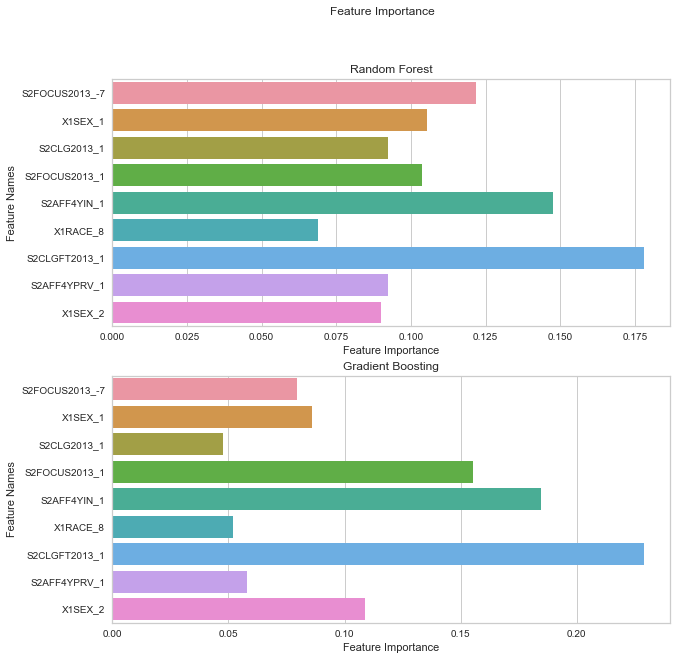

In [69]:
#plotting feature importances 
fig, axes = plt.subplots(2, figsize=(10, 10))
fig.suptitle('Feature Importance')

fig1 = sns.barplot(x='Importance', y='Features',data=fimp_rf, ax=axes[0])
fig1.set_title('Random Forest')
fig1.set_xlabel('Feature Importance')
fig1.set_ylabel('Feature Names')


fig2 = sns.barplot(x='Importance', y='Features',data=fimp_gb, ax=axes[1])
fig2.set_title('Gradient Boosting')
fig2.set_xlabel('Feature Importance')
fig2.set_ylabel('Feature Names')

---
## 5) Visualizations

#### Factors influencing Post-Secondary Education and Employment 
- Correlation Matrix 

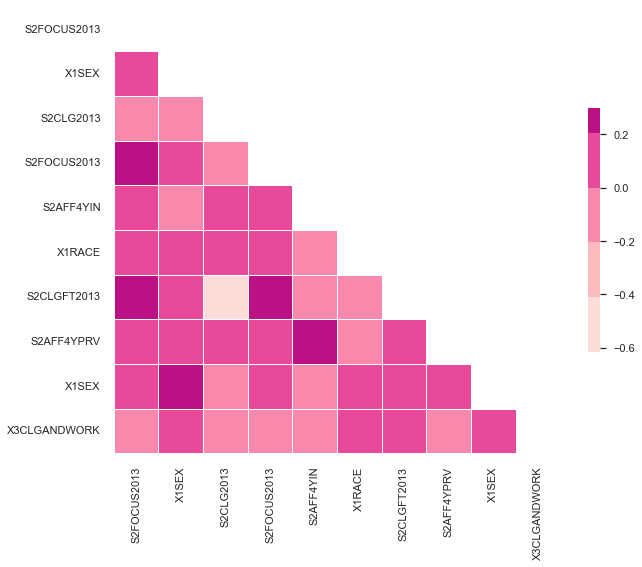

In [71]:
a = sns.color_palette("RdPu") 

sns.set_theme(style="white")

# Compute the correlation matrix
corr = df[['S2FOCUS2013', 'X1SEX', 'S2CLG2013', 'S2FOCUS2013','S2AFF4YIN', 'X1RACE', 'S2CLGFT2013', 'S2AFF4YPRV', 'X1SEX', 'X3CLGANDWORK']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=a, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Rotation = 90
plt.xticks(rotation = 90) 

# Change the font size to 1.5
plt.show()

___
## 6) Conclusions and Results

- We observe that generally white, male students who intend to pursue higher education while they are in high school, are the ones who end up with education and employment opportunities.
- Based on the analysis one may deduce that other factors like ability to afford private education may also be an impactful.

---
## References
- Feature Selection Guidance:  https://towardsdatascience.com/feature-selection-techniques-for-classification-and-python-tips-for-their-application-10c0ddd7918b
- Lab 5,6 Solutions
- PCA_Lecture_21.html https://canvas.cmu.edu/courses/32980/files/9487200?module_item_id=5442758&fd_cookie_set=1 
- Pipeline: Pipelines_WrapingUp_inclassL26.html
- Gradient Boosting: Lab 9 Solutions
- https://towardsdatascience.com/semi-automated-exploratory-data-analysis-eda-in-python-7f96042c9809
- Exploratory Data Analysis and Visualization Notes
- https://panjeh.medium.com/figure-size-plot-confusion-matrix-in-scikit-learn-2c66f3a69d81
- https://www.geeksforgeeks.org/how-to-rotate-x-axis-tick-label-text-in-matplotlib/